# Análisis Bivariado

Analizaremos cada variable explicativa y su relación con la variable obetivo de forma visual y con test estadísticos. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder

In [3]:
def remove_outliers_iqr(df, column, sensitivity=1.5):
    """
    Remove outliers from a pandas DataFrame.

    Parameters:
        df (pandas.DataFrame): The DataFrame from which to remove outliers.
        column (str): The name of the column to check for outliers.
        sensitivity (float): The sensitivity coefficient used to define what constitutes an outlier.
            Smaller values mean more aggressive outlier removal.

    Returns:
        pandas.DataFrame: A new DataFrame with outliers removed.
    """
    # Calculate IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for what is considered an outlier
    lower_bound = Q1 - sensitivity * IQR
    upper_bound = Q3 + sensitivity * IQR

    # Return the DataFrame without outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


In [4]:
def generate_lollipop(df, categorical_var, y_lim_inf = 0, y_lim_sup = 100, xticks_rotation = 0):
    ''' 
    Graficar un Lollipop de la proporción de clasificados como mala paga de acuerdo a una variable categórica   
    '''

    # Calcular proporción y cantidad absoluta de indivduos clase 1
    summary = df.groupby(categorical_var).agg(
        absolute = ('clase', 'sum'),  # Cantidad absoluta de individuos de clase 1
        total = ('clase', 'count')  # Cantidad total de individuos por oficina
        )

    summary = summary.assign(rate = lambda x: 100 * x['absolute'] / x['total'])  # Calcula la proporción de individuos de clase 1
    summary = summary.reset_index()
    summary = summary.sort_values(by = 'rate', ascending = False)
    
    # Graficar Lollipop
    plt.figure(figsize = (8,5))
    plt.stem(summary[categorical_var], summary['rate'], basefmt=" ")

    plt.xlabel(categorical_var)
    plt.ylabel('Proporción de Mal Pago (%)')
    plt.title(f'Proporción de MAL PAGO por {categorical_var}')
    plt.ylim(y_lim_inf, y_lim_sup*1.2)

    # Labels
    for i, row in summary.iterrows():
        text = '{:.1f}%\n({})'.format(row['rate'], row['absolute'])
        plt.text(row[categorical_var], row['rate']+ y_lim_sup*0.05 , text, ha='center')

    plt.xticks(rotation=xticks_rotation)
    
    plt.show()

In [5]:
df = pd.read_csv('data/raw/all_data.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24786 entries, 0 to 24785
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cedula              24786 non-null  int64  
 1   oficina             24786 non-null  object 
 2   categoria           24786 non-null  object 
 3   tiempo_desembolso   24786 non-null  int64  
 4   monto               24786 non-null  float64
 5   saldo               24786 non-null  float64
 6   plazo               24786 non-null  int64  
 7   tasa                24786 non-null  float64
 8   cuota               24786 non-null  int64  
 9   garantia            24786 non-null  object 
 10  diasmora            24786 non-null  int64  
 11  forma_de_pago       24786 non-null  int64  
 12  reestructurado      24786 non-null  int64  
 13  edad                24786 non-null  int64  
 14  ocupacion           24786 non-null  object 
 15  nivel_educativo     24786 non-null  object 
 16  ingr

In [7]:
# Convertimos la variable objetivo a 0 y 1 para simplificar código
df.clase = df.clase.map({'Malo': 1, 'Bueno': 0})

In [8]:
df

,cedula,oficina,categoria,tiempo_desembolso,monto,saldo,plazo,tasa,cuota,garantia,...,antiguedad_empresa,estado_civil,sexo,personas,tipo_vivienda,tipo_contrato,aportes,numero_creditos,antiguedad_entidad,clase
0,6754,Santa Fe,E,63,500000.0,411775.0,18,3.1667,36868,P,...,6,Unión Libre,Masculino,0,NaN,NaN,69000.0,1,6,1
1,17922,Usaquen,E,65,2000000.0,1563604.0,24,3.2083,120761,P,...,8,Soltero,Masculino,0,NaN,NaN,0.0,1,6,1
2,167,Chapinero,E,60,800000.0,658843.0,18,3.1667,58990,P,...,14,Soltero,Femenino,0,NaN,NaN,82000.0,1,5,1
3,23093,Santa Fe,E,57,800000.0,744568.0,21,3.2083,52945,P,...,8,Casado,Masculino,0,Familiar,Término Indefinido,82000.0,1,5,1
4,16530,Chapinero,E,58,14153655.0,13567368.0,48,2.8750,547318,R,...,0,Casado,Masculino,2,Propia,NaN,300000.0,1,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24781,7,Usaquen,A,20,6000000.0,2719389.0,36,2.0000,210640,P,...,11,Casado,Masculino,3,Familiar,Término Indefinido,6000.0,1,2,0
24782,6,Bosa,A,8,12000000.0,10726957.0,48,2.0834,397891,R,...,7,Unión Libre,Masculino,1,Familiar,Término Indefinido,131000.0,3,4,0
24783,5,Tunjuelito,A,14,2000000.0,966688.0,24,2.1742,108602,P,...,8,Soltero,Masculino,0,Propia,Término Indefinido,0.0,3,7,0
24784,4,Santa Fe,A,5,900000.0,684264.0,18,2.1742,60991,P,...,11,Soltero,Masculino,0,NaN,Término Indefinido,0.0,1,1,0


## 1. Cédula

Esta columna no aporta información desde el punto de vista analítico.

In [9]:
df = df.drop(columns='cedula')

## 2. Oficina

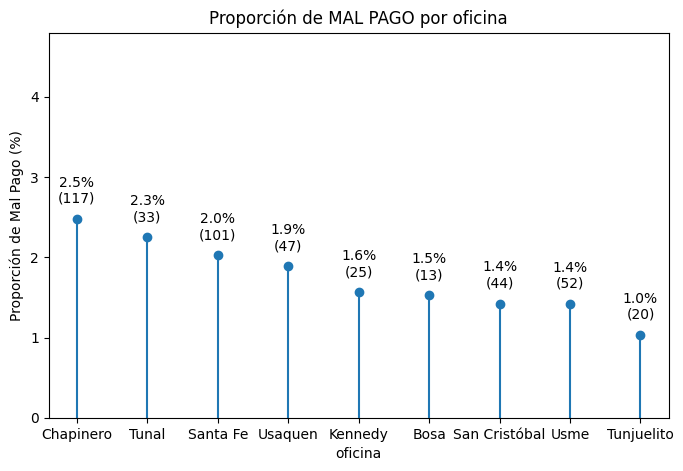

In [10]:
generate_lollipop(df, 'oficina', 0, 4)

Vemos de forma preliminar es más probable que un cliente sea "Buena paga" en las localidades de San Cristóbal, Usme y Tunjuelito.

# 3.  Categoría

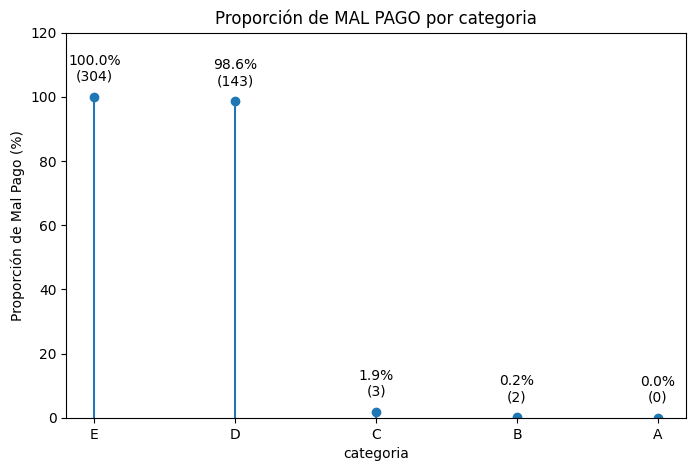

In [11]:
generate_lollipop(df, 'categoria', 0, 100)

Observamos que existe una gran correlación entre la variable categoría y la variable objetivo, ya que los individuos tipificados como mal pago se encuentran concentrados en las categorías E y D.

Es decir, la variable categoría separa casi completamente a los clientes buena paga y mala paga, por lo tanto, no tiene sentido usarla como explicativa

## 4. Tiempo de Desembolso

En este campo se presenta un registro con valor negativo, el cual debemos reemplazar o eliminar

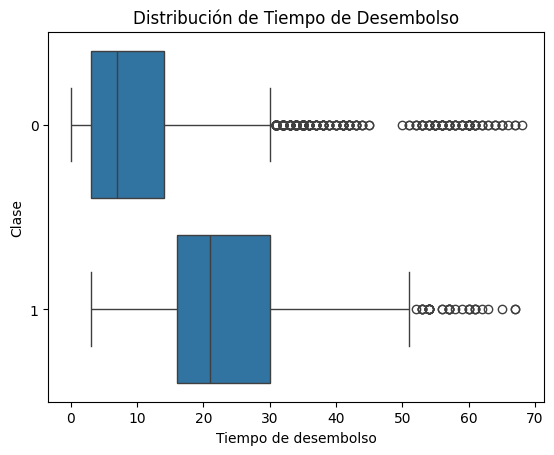

In [12]:
sns.boxplot(
    data = df[df.tiempo_desembolso >= 0], 
    x = 'tiempo_desembolso', 
    y = 'clase', orient = 'h'
)
plt.title('Distribución de Tiempo de Desembolso')
plt.xlabel('Tiempo de desembolso')
plt.ylabel('Clase')
plt.show()

Se observa una leve tendencia a que el desembolso para los individuos clasificados como mala paga es mayor

## 5. Monto

En esta columna observamos la presencia de una distribución sesgada a la derecha, y la existencia de outliers de acuerdo a la regla intercuartil

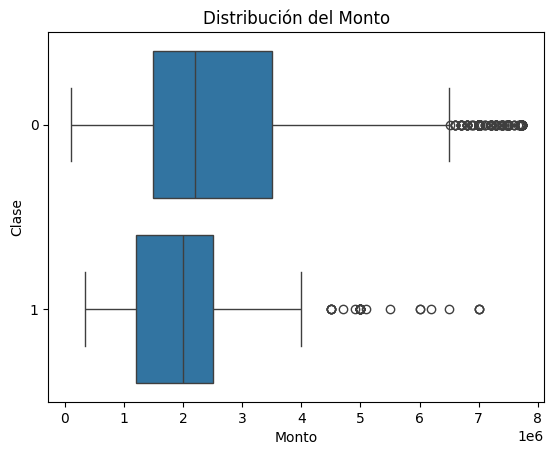

In [13]:
sns.boxplot(
    data = remove_outliers_iqr(df, 'monto'), 
    x = 'monto', 
    y = 'clase', orient = 'h'
)
plt.title('Distribución del Monto')
plt.xlabel('Monto')
plt.ylabel('Clase')
plt.show()

Se observa una leve tendencia a que el monto para los individuos clasificados como mala paga es menor

## 6. Saldo

En esta columna observamos la presencia de una distribución sesgada a la derecha, y la existencia de outliers de acuerdo a la regla intercuartil

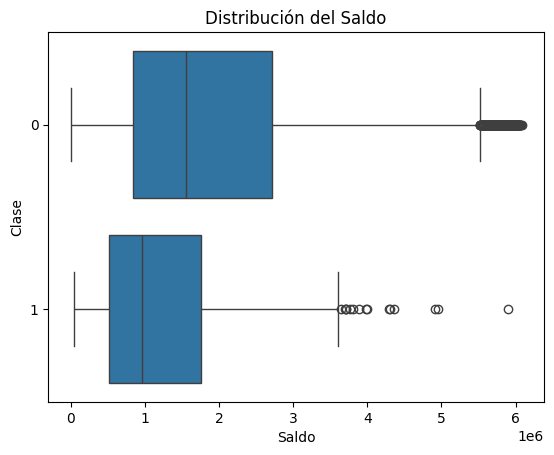

In [14]:
sns.boxplot(
    data = remove_outliers_iqr(df, 'saldo'), 
    x = 'saldo', 
    y = 'clase', orient = 'h'
)
plt.title('Distribución del Saldo')
plt.xlabel('Saldo')
plt.ylabel('Clase')
plt.show()

De forma similar al monto, se observa una leve tendencia a que el saldo para los individuos clasificados como mala paga es menor

## 7. Plazo

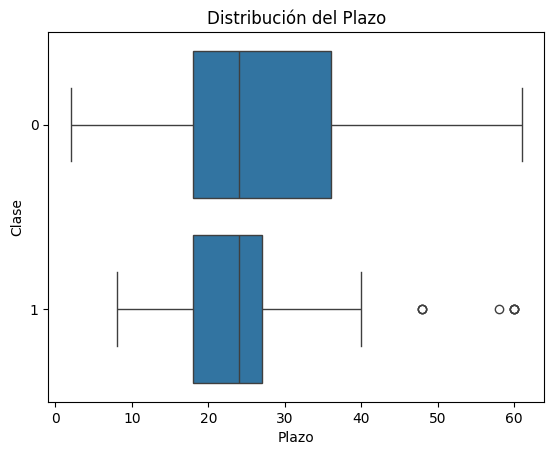

In [15]:
sns.boxplot(
    data = remove_outliers_iqr(df, 'plazo'), 
    x = 'plazo', 
    y = 'clase', orient = 'h'
)
plt.title('Distribución del Plazo')
plt.xlabel('Plazo')
plt.ylabel('Clase')
plt.show()

No se observa una diferencia evidente entre el plazo de los clientes buena paga y los mala paga

## 8. Tasa

Observamos que el 93.1% de clientes manejan una tasa de interés de 2.1742

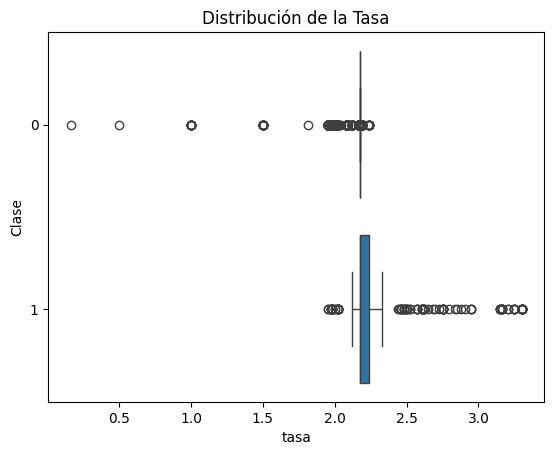

In [16]:
sns.boxplot(
    data =  df, 
    x = 'tasa', 
    y = 'clase', orient = 'h'
)
plt.title('Distribución de la Tasa')
plt.xlabel('tasa')
plt.ylabel('Clase')
plt.show()

Observamos que hay clientes mala paga que se caracterizan por tener tasas de interés muy altas.

## 9. Cuota

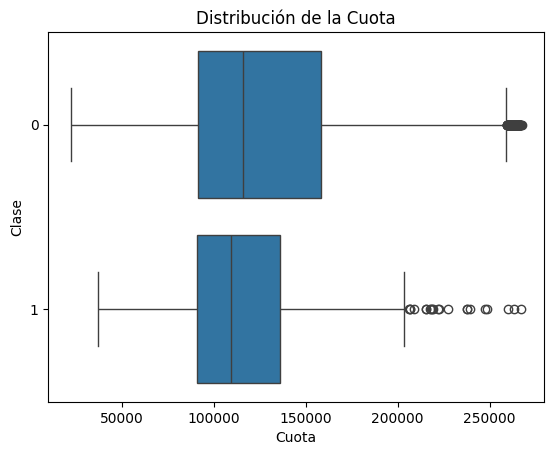

In [17]:
sns.boxplot(
    data =  remove_outliers_iqr(df, 'cuota'), 
    x = 'cuota', 
    y = 'clase', orient = 'h'
)
plt.title('Distribución de la Cuota')
plt.xlabel('Cuota')
plt.ylabel('Clase')
plt.show()

No se observa una diferencia evidente entre la cuota de clientes buena y mala paga

## 10. Garantía

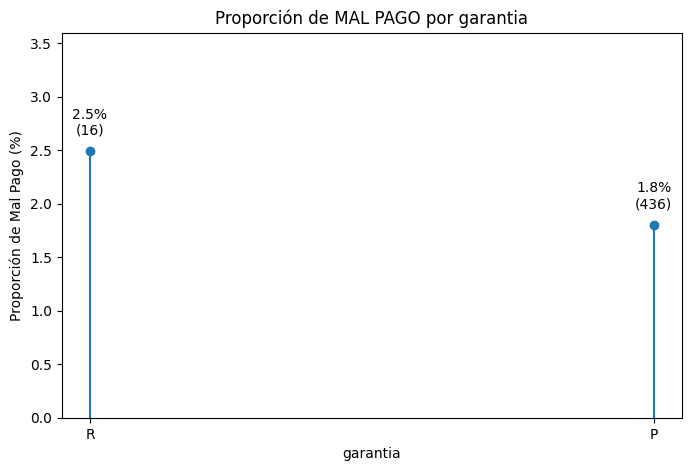

In [18]:
generate_lollipop(df, 'garantia', 0, 3)

No se evidencia relación entre las dos variables

## 11. Días de Mora

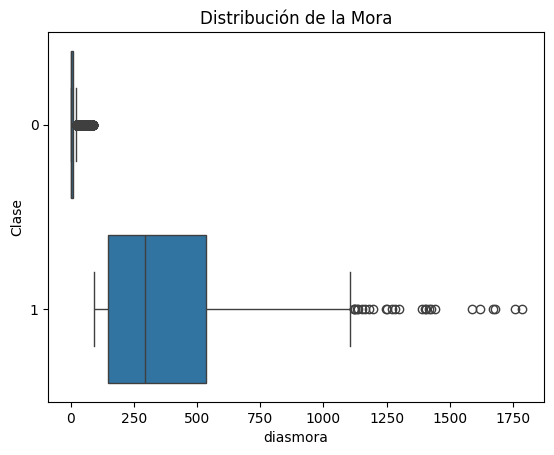

In [19]:
sns.boxplot(
    data =  df, 
    x = 'diasmora', 
    y = 'clase', orient = 'h'
)
plt.title('Distribución de la Mora')
plt.xlabel('diasmora')
plt.ylabel('Clase')
plt.show()

In [20]:
df[df['clase'] == 1]['diasmora'].describe()

count     452.000000
mean      409.778761
std       339.501872
min        91.000000
25%       149.500000
50%       295.500000
75%       537.000000
max      1784.000000
Name: diasmora, dtype: float64

Esta variable está estrechamente relacionada con la variable objetivo, pero en mi opinión no debería considerarse como una variable explicativa, ya que la idea es identificar a los clientes mala paga antes de que empiecen a tener mora en sus pagos

## 12. Forma de pago

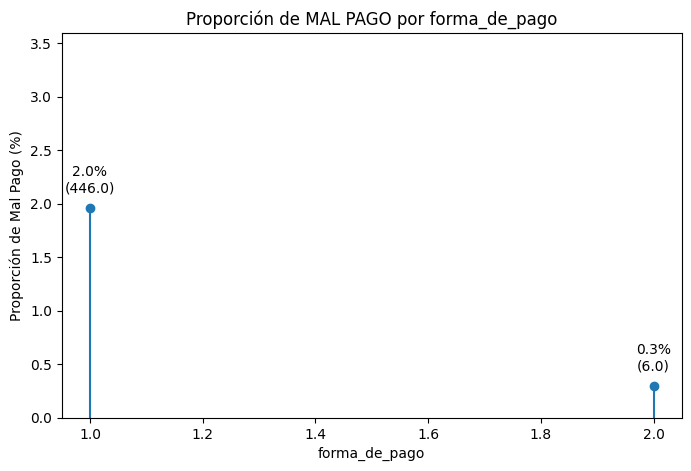

In [21]:
generate_lollipop(df, 'forma_de_pago', 0, 3)

Aunque hay pocos clientes que tienen la forma de pago número 2, podemos observar que hay una mayor proporción de malos clientes en la forma de pago número dos. 

## 13. Reestructurado

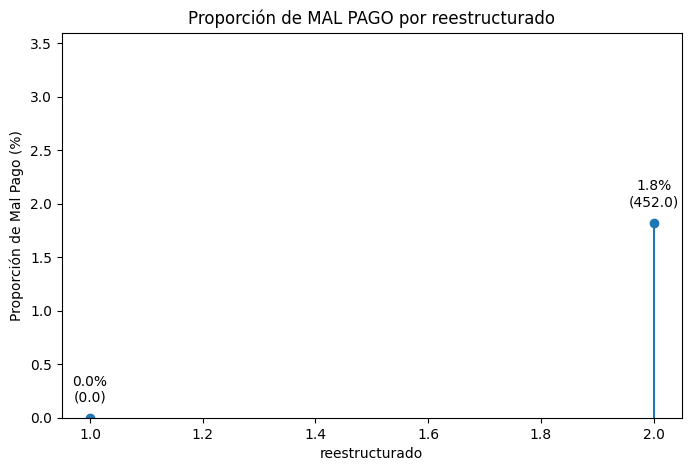

In [22]:
generate_lollipop(df, 'reestructurado', 0, 3)

Observamos que todos los clientes con restructurado = 1 son buenos clientes, sin embargo, la muestra no es representativa.

## 14. Edad

### Edad como variable contínua

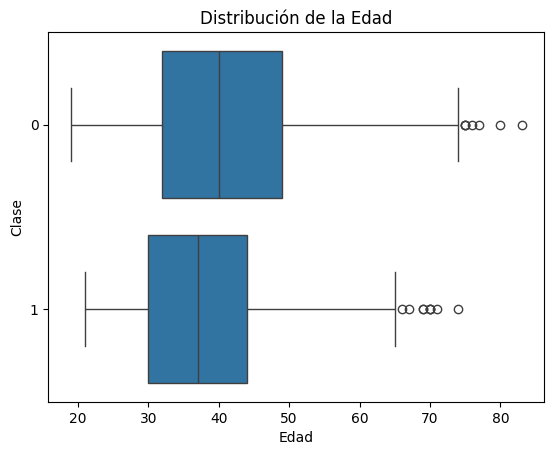

In [23]:
sns.boxplot(
    data =  df, 
    x = 'edad', 
    y = 'clase', orient = 'h'
)
plt.title('Distribución de la Edad')
plt.xlabel('Edad')
plt.ylabel('Clase')
plt.show()

### Edad como variable discreta (Deciles)

In [24]:
# Hallar los deciles de acuerdo a la edad.
age_deciles = np.percentile(df["edad"], [10*i for i in range(0,11)])
# Segmentar a la población en deciles de edad
df["edad_deciles"] = pd.cut(df["edad"], age_deciles).astype('string')

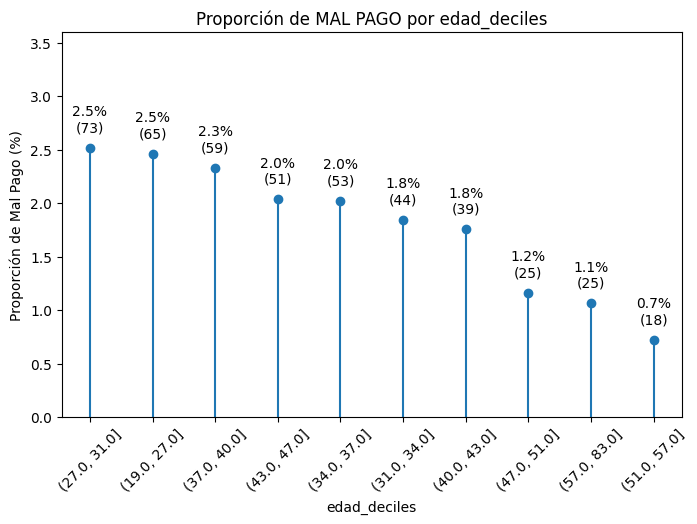

In [25]:
generate_lollipop(df, 'edad_deciles', 0, 3, xticks_rotation=45)

Los segmentos donde hay mayor proporción de clientes malos son
- 27 a 31 años
- 19 a 27 años
- 37 a 40 años

## 15. Ocupación

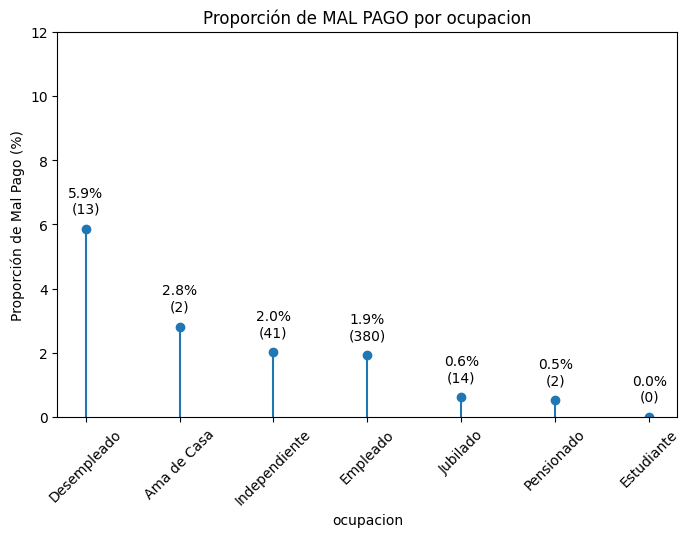

In [26]:
generate_lollipop(df, 'ocupacion', y_lim_sup=10, xticks_rotation= 45)

En el segmento de desempleados se presenta mayor proporción de clientes malos

## 16. Nivel Educativo

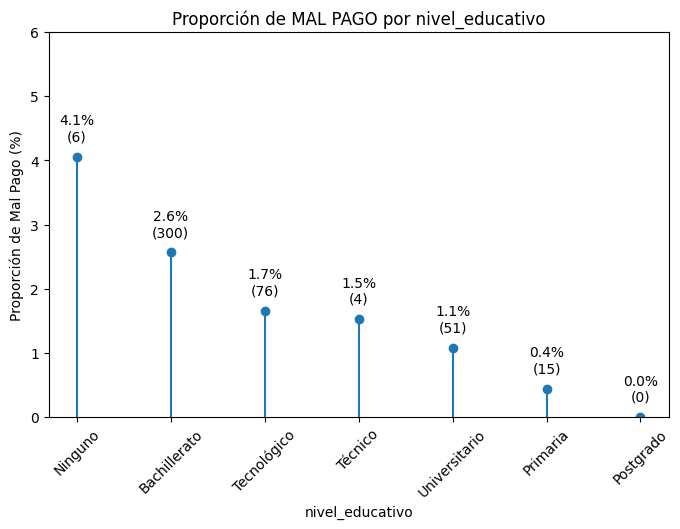

In [27]:
generate_lollipop(df, 'nivel_educativo', y_lim_sup=5, xticks_rotation= 45)

## 17. Ingreso Total

Esta variable tiene una distribución sesgada

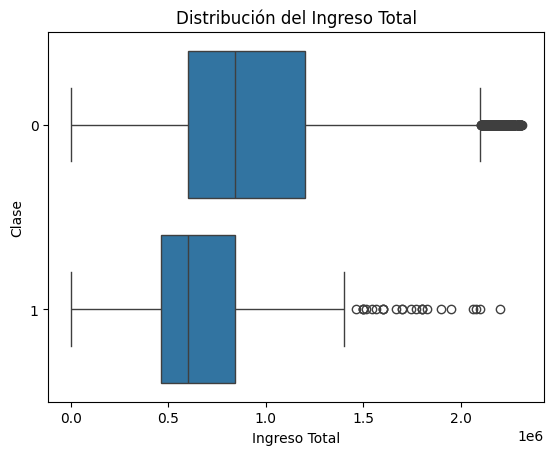

In [28]:
sns.boxplot(
    data =  remove_outliers_iqr(df, 'ingreso_total'), 
    x = 'ingreso_total', 
    y = 'clase', orient = 'h'
)
plt.title('Distribución del Ingreso Total')
plt.xlabel('Ingreso Total')
plt.ylabel('Clase')
plt.show()

## 18. Egreso Total

Esta variable tiene una distribución sesgada

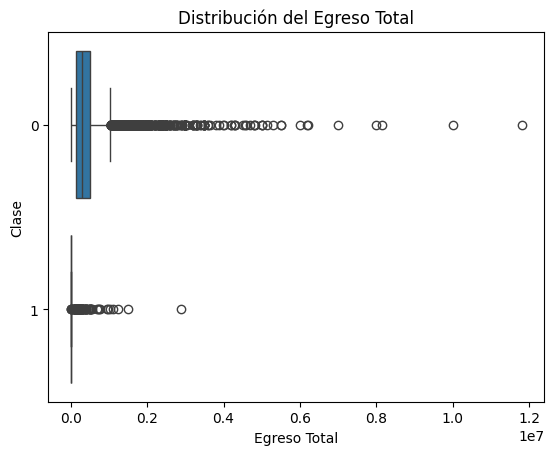

In [29]:
sns.boxplot(
    data = df, 
    x = 'egreso_total', 
    y = 'clase', 
    orient = 'h'
)
plt.title('Distribución del Egreso Total')
plt.xlabel('Egreso Total')
plt.ylabel('Clase')
plt.show()

## 19. Estrato

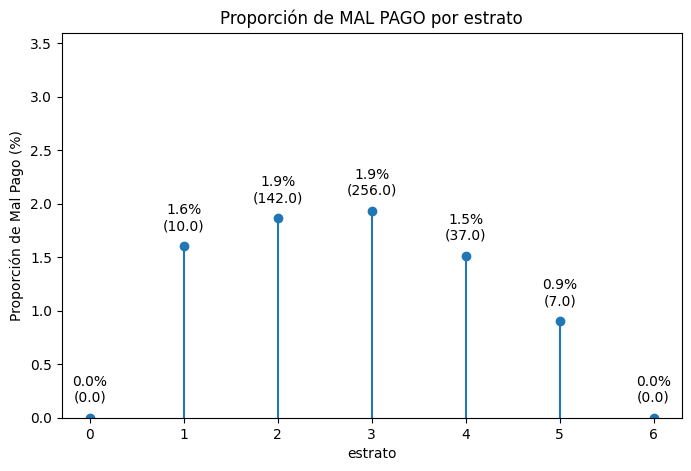

In [30]:
generate_lollipop(df, 'estrato', y_lim_sup=3)

## 20. Antiguedad Empresa

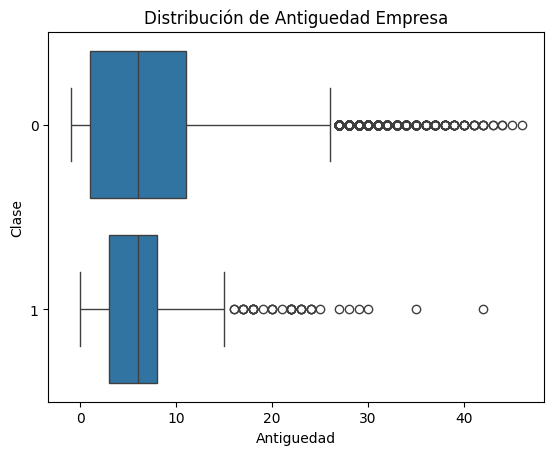

In [31]:
sns.boxplot(
    data = df, 
    x = 'antiguedad_empresa', 
    y = 'clase', 
    orient = 'h'
)
plt.title('Distribución de Antiguedad Empresa')
plt.xlabel('Antiguedad')
plt.ylabel('Clase')
plt.show()

## 21. Estado Civil

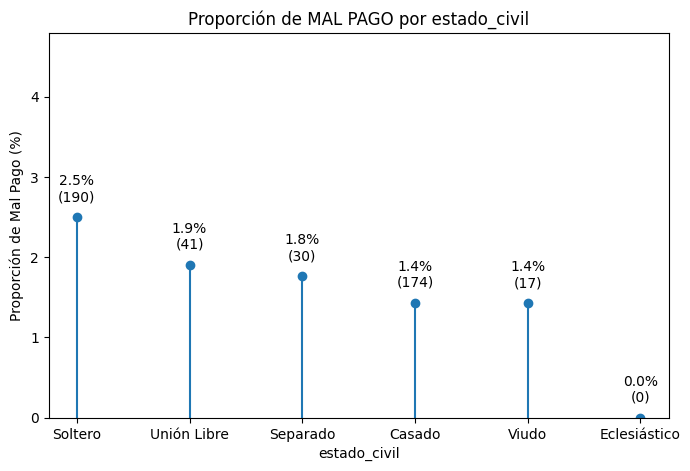

In [32]:
generate_lollipop(df, 'estado_civil', y_lim_sup=4)

Hya mayor proporcion de clientes malos en el segmento de solteros

## 22. Sexo

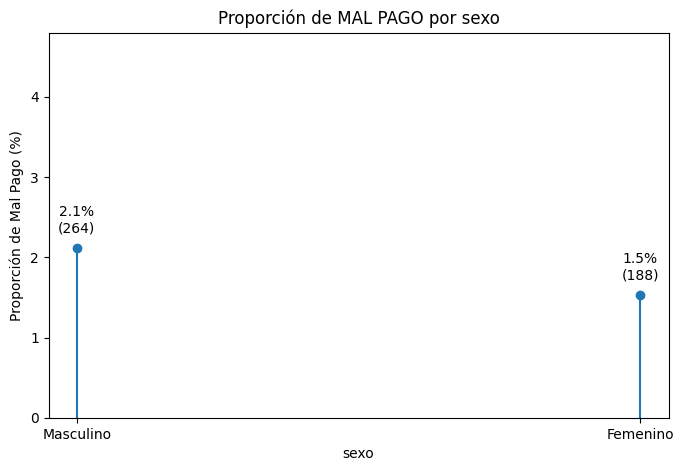

In [33]:
generate_lollipop(df, 'sexo', y_lim_sup=4)

Hay una leve tendencia a que las mujeres sean más cumplidas al pagar

## 23. Personas

In [34]:
def personas_mapeo(x):
    if x == 0:
        return '[0]'
    elif x == 1 or x == 2:
        return '[1,2]'
    else: 
        return '[3+]'
df['personas_discreta'] = df['personas'].map(personas_mapeo)

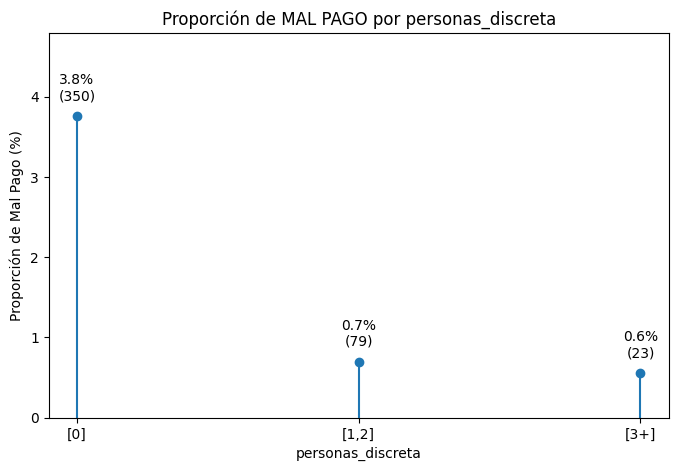

In [35]:
generate_lollipop(df, 'personas_discreta', y_lim_sup=4)

Parece ser que es más probable que los clientes sin personas a cargo tienen mayor probabilidad de ser malos

## 24. Tipo de vivienda

Tenemos 17% de valores faltantes

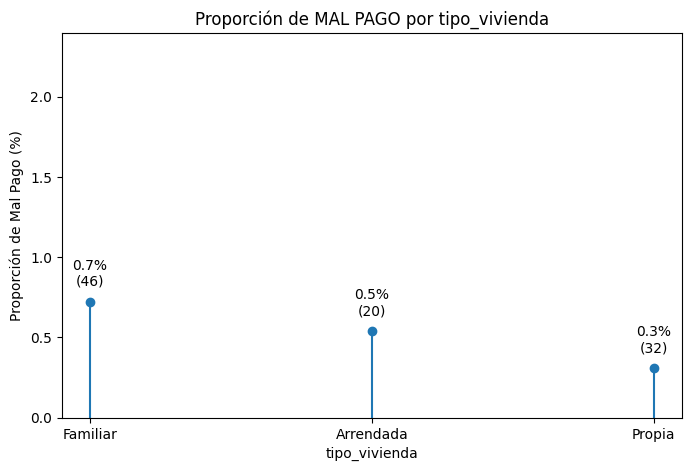

In [36]:
generate_lollipop(df, 'tipo_vivienda', y_lim_sup=2)

Existe una leve tendencia a que las personas con casa propia sean mejores clientes

## 25. Tipo de Contrato

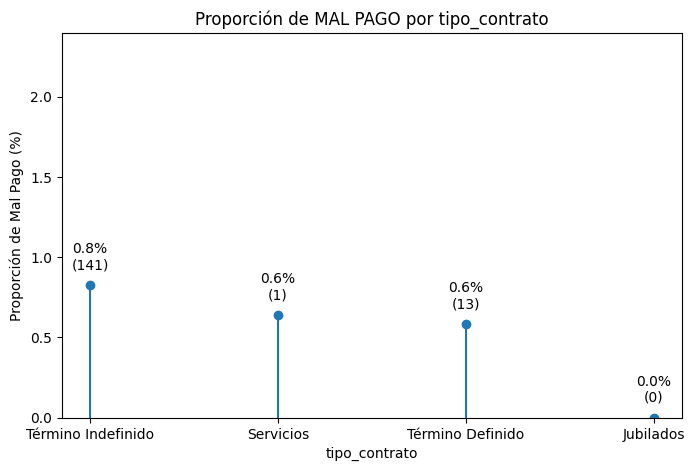

In [37]:
generate_lollipop(df, 'tipo_contrato', y_lim_sup=2)

## 26. Aportes

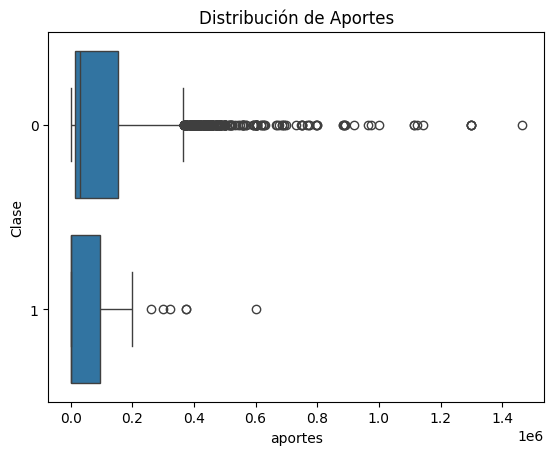

In [38]:
sns.boxplot(
    data = df, 
    x = 'aportes', 
    y = 'clase', 
    orient = 'h'
)
plt.title('Distribución de Aportes')
plt.xlabel('aportes')
plt.ylabel('Clase')
plt.show()

No se observa ninguna relación con la variable objetivo

## 27. Numero de créditos

In [39]:
def num_creditos(x):
    if x == 1:
        return '[1]'
    elif x == 2 or x == 3:
        return '[2,3]'
    else: 
        return '[4+]'
df['num_creditos_discreta'] = df['numero_creditos'].map(num_creditos)

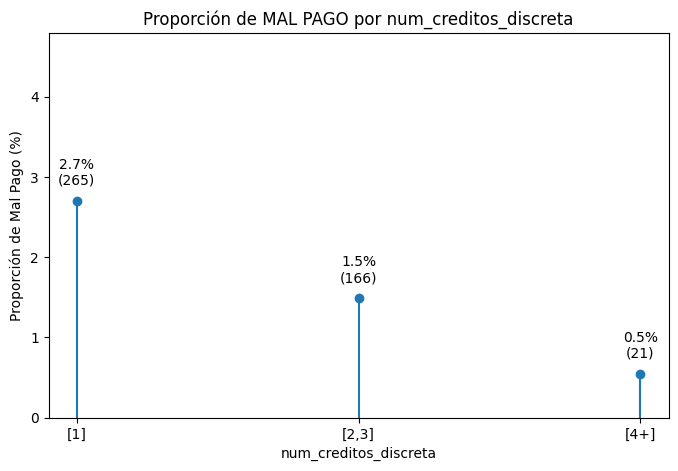

In [40]:
generate_lollipop(df, 'num_creditos_discreta', y_lim_sup=4)

## 28. Antiguedad Entidad

In [41]:
df['antiguedad_entidad_discreta'] = df['antiguedad_entidad'].map(num_creditos)

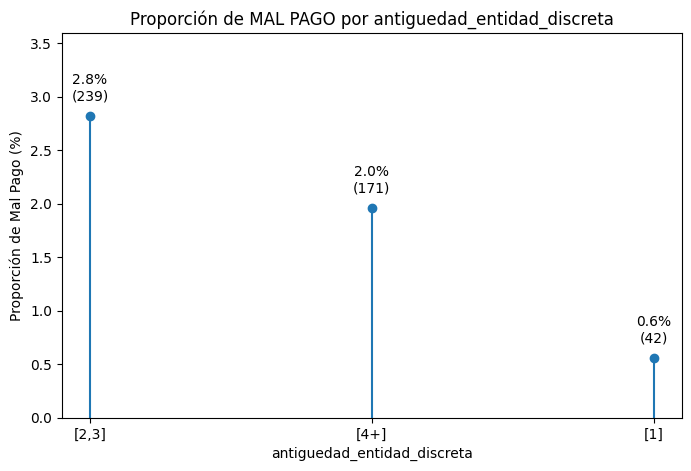

In [42]:
generate_lollipop(df, 'antiguedad_entidad_discreta', y_lim_sup= 3)

El 30% de la población lleva menos de un año en la entidad y solo el 0.6% son malos clientes, de manera que, este es el segmento con mayor probabilidad de buena paga

# Análisis Multivariado Inicial

Con el fin de confirmar algunas de las suposiciones conjeturadas a partir de los gráficos de dos variables, implementaremos un análisis de regresión logística para ver la correlación de las variables con la variable objetivo. 

In [43]:
nominales = ['oficina', 'ocupacion', 'estado_civil', 'sexo']
ordinales = ['edad_deciles', 'nivel_educativo', 'personas_discreta', 'num_creditos_discreta', 'antiguedad_entidad_discreta']
categoricas = nominales + ordinales

In [44]:
enteras = ['tiempo_desembolso', 'plazo', 'forma_de_pago', 'estrato' ]
continuas = ['monto', 'saldo', 'tasa', 'cuota', 'ingreso_total', 'egreso_total']
numericas = enteras + continuas

In [45]:
objetivo = ['clase']
df_modelo = df[categoricas + numericas + objetivo]

In [46]:
df_modelo.head()

,oficina,ocupacion,estado_civil,sexo,edad_deciles,nivel_educativo,personas_discreta,num_creditos_discreta,antiguedad_entidad_discreta,tiempo_desembolso,plazo,forma_de_pago,estrato,monto,saldo,tasa,cuota,ingreso_total,egreso_total,clase
0,Santa Fe,Empleado,Unión Libre,Masculino,"(27.0, 31.0]",Bachillerato,[0],[1],[4+],63,18,1,3,500000.0,411775.0,3.1667,36868,372315.0,0.0,1
1,Usaquen,Empleado,Soltero,Masculino,"(37.0, 40.0]",Bachillerato,[0],[1],[4+],65,24,1,2,2000000.0,1563604.0,3.2083,120761,900000.0,0.0,1
2,Chapinero,Empleado,Soltero,Femenino,"(51.0, 57.0]",Técnico,[0],[1],[4+],60,18,1,4,800000.0,658843.0,3.1667,58990,800000.0,0.0,1
3,Santa Fe,Empleado,Casado,Masculino,"(27.0, 31.0]",Bachillerato,[0],[1],[4+],57,21,1,3,800000.0,744568.0,3.2083,52945,325000.0,80000.0,1
4,Chapinero,Independiente,Casado,Masculino,"(43.0, 47.0]",Universitario,"[1,2]",[1],[4+],58,48,1,5,14153655.0,13567368.0,2.8750,547318,2500000.0,1500000.0,1


### Codificación de variables ordinales

In [47]:
df_modelo.loc[:,ordinales] = df[ordinales].fillna('-1')

In [48]:
# Mapeos para la codificación
ordinal_mapping =  [
    {'col': 'nivel_educativo', 'mapping': {'-1': -1, 'Ninguno': 0, 'Primaria': 1, 'Bachillerato': 2, 'Tecnico': 3, 'Tecnologico': 4, 'Universitario': 5, 'Posgrado': 6}},
    {'col': 'personas_discreta', 'mapping': {'-1': -1, '0': 0, '[1,2]': 1, '[3+]': 2}},
    {'col': 'num_creditos_discreta', 'mapping': {'-1': -1, '1': 1, '[2,3]': 2, '[4+]': 3}},
    {'col': 'antiguedad_entidad_discreta', 'mapping': {'-1': -1, '1': 1, '[2,3]': 2, '[4+]': 3}},
    {'col': 'edad_deciles', 'mapping': None}
]

In [49]:
# Codificar variables ordinales usando enteros consecutivos y preservando el orden natural
ordinal_encoder = OrdinalEncoder(cols=ordinales, mapping=ordinal_mapping)
df_modelo = ordinal_encoder.fit_transform(df_modelo)

In [50]:
df_modelo[ordinales]

,edad_deciles,nivel_educativo,personas_discreta,num_creditos_discreta,antiguedad_entidad_discreta
0,-1.0,2.0,-1.0,-1.0,3.0
1,-1.0,2.0,-1.0,-1.0,3.0
2,-1.0,-1.0,-1.0,-1.0,3.0
3,-1.0,2.0,-1.0,-1.0,3.0
4,-1.0,5.0,1.0,-1.0,3.0
...,...,...,...,...,...
24781,-1.0,2.0,2.0,-1.0,2.0
24782,-1.0,5.0,1.0,2.0,3.0
24783,-1.0,5.0,-1.0,2.0,3.0
24784,-1.0,2.0,-1.0,-1.0,-1.0


### Codificación de Variables Nominales

In [51]:
# Codificar variables nominales usando variables dummy
onehot_encoder = OneHotEncoder(cols=nominales)
df_modelo = onehot_encoder.fit_transform(df_modelo)  

# Análisis de Regresión

## Variables ordinales

In [52]:
# Se definen las variables explicativas y la variable objetivo
X = df_modelo[ordinales]
y = df_modelo[objetivo]

# Se ajusta una regresión logística
log_reg = sm.Logit(y, X).fit()

# Resumen de la regresión
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.078137
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  clase   No. Observations:                24786
Model:                          Logit   Df Residuals:                    24781
Method:                           MLE   Df Model:                            4
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.1422
Time:                        12:30:56   Log-Likelihood:                -1936.7
converged:                       True   LL-Null:                       -2257.8
Covariance Type:            nonrobust   LLR p-value:                1.107e-137
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
edad_deciles                    4.7515      0.112     42.345      0.000   

### Variables nominales

In [53]:
# Se definen las variables explicativas y la variable objetivo
X = df_modelo.drop(columns = ordinales + numericas + objetivo)
y = df_modelo[objetivo]

# Se ajusta una regresión logística
log_reg = sm.Logit(y, X).fit()

# Resumen de la regresión
print(log_reg.summary())

         Current function value: 0.088704
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  clase   No. Observations:                24786
Model:                          Logit   Df Residuals:                    24762
Method:                           MLE   Df Model:                           23
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                 0.02622
Time:                        12:30:57   Log-Likelihood:                -2198.6
converged:                      False   LL-Null:                       -2257.8
Covariance Type:            nonrobust   LLR p-value:                 8.010e-15
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
oficina_1         -0.8911        nan        nan        nan         nan         nan
oficina_2         -1.0042        nan        nan      

c:\Users\USUARIO\Documents\Pruebas Tecnicas\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


No obtenemos ninguna conclusión con este test

### Variables Numéricas

In [54]:
# Se definen las variables explicativas y la variable objetivo
X = df_modelo[numericas]
y = df_modelo[objetivo]

# Se ajusta una regresión logística
log_reg = sm.Logit(y, X).fit()

# Resumen de la regresión
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.032760
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                  clase   No. Observations:                24786
Model:                          Logit   Df Residuals:                    24776
Method:                           MLE   Df Model:                            9
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.6404
Time:                        12:30:57   Log-Likelihood:                -812.00
converged:                       True   LL-Null:                       -2257.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
tiempo_desembolso     0.6107      0.023     26.197      0.000       0.565       0.656
plazo  

## Exportación

In [55]:
df_modelo.head()

,oficina_1,oficina_2,oficina_3,oficina_4,oficina_5,oficina_6,oficina_7,oficina_8,oficina_9,ocupacion_1,...,plazo,forma_de_pago,estrato,monto,saldo,tasa,cuota,ingreso_total,egreso_total,clase
0,1,0,0,0,0,0,0,0,0,1,...,18,1,3,500000.0,411775.0,3.1667,36868,372315.0,0.0,1
1,0,1,0,0,0,0,0,0,0,1,...,24,1,2,2000000.0,1563604.0,3.2083,120761,900000.0,0.0,1
2,0,0,1,0,0,0,0,0,0,1,...,18,1,4,800000.0,658843.0,3.1667,58990,800000.0,0.0,1
3,1,0,0,0,0,0,0,0,0,1,...,21,1,3,800000.0,744568.0,3.2083,52945,325000.0,80000.0,1
4,0,0,1,0,0,0,0,0,0,0,...,48,1,5,14153655.0,13567368.0,2.8750,547318,2500000.0,1500000.0,1


In [56]:
df_modelo.to_csv('data/intermediate/df_modelo.csv', index = False)